
# TFM - Modelos de Propensión para Campañas Comerciales

**Autor:** Grupo 4

#### En este segundo Notebook realizaremos la implementación de dos modelos predictivos:

- **Primer modelo**: Utilizando variables previamente calculadas junto con otros campos del dataset, este modelo analizará el comportamiento del cliente y nos permitirá predecir si responderá o no a una campaña.

- **Segundo modelo**: Este modelo será entrenado con datos históricos (de años anteriores) y empleará variables calculadas para simular el lanzamiento de campañas en esos años. Su objetivo es predecir el comportamiento de los clientes en el año **2025**, específicamente anticipando:
  - El **importe** esperado.
  - El **ticket medio** de cada cliente.

  El modelo realizará predicciones en dos escenarios:
  1. En caso de aplicar una campaña.
  2. En caso de no aplicar ninguna campaña.

  Para ello, se han definido campañas específicas para cada uno de los segmentos previamente identificados, y dichas campañas serán aplicadas en base al segmento al que pertenezca cada cliente.

---

## 1. Carga de librerías

In [ ]:
# 1. Librerías
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.special import expit
import joblib
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

import numpy as np
warnings.filterwarnings("ignore")


c:\Users\67672279\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



---

## 2. Carga del dataset obtenido en el primer Notebook, el clasificador manual

In [2]:
# 2. Cargar tu dataset
data = pd.read_excel('./Data/Resultados/segmentacion_v6.xlsx')
data.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,Edad,Metodo_pago,Genero,Cluster_Economico
0,C100004,130.43,32.6075,4,711,2023,Supermercado,Supermercado,1,Tienda física,61,Otras Tarjetas,Masculino,Dormidos
1,C100005,196.48,98.2400,2,110,2024,Moda,Supermercado,2,Tienda física,34,Efectivo,Masculino,Ocasionales
2,C100006,497.88,99.5760,5,254,2024,Moda,Libros,3,Tienda física,44,Otras Tarjetas,Masculino,Dormidos
3,C100012,423.60,70.6000,6,200,2024,Souvenirs,Perfumería,5,Tienda física,25,Efectivo,Masculino,ECI Lovers
4,C100019,120.13,60.0650,2,634,2023,Supermercado,Supermercado,1,Tienda física,21,Otras Tarjetas,Femenino,Dormidos



---

## 3. Calculo de variables necesarias para el primer modelo

### Justificación de la creación de la variable objetivo: 'Respondio'

Dado que nuestro dataset no proviene directamente de ECI, sino que ha sido generado a partir de datos públicos subidos por terceros, **no contamos con información real sobre la respuesta de los clientes a campañas anteriores**. Por esta razón, nos hemos visto obligados a **simular esta variable** con una base razonada y realista.

#### Objetivo del modelo
Para este primer modelo, necesitábamos una **variable objetivo binaria** ('Respondio') que indicara si un cliente respondió o no a una campaña. Al no disponer de esta columna, la generamos teniendo en cuenta varios factores de comportamiento del cliente:

---

### Variables consideradas para calcular 'Respondio'

- **Tasa Promedio de Retorno** ('Tasa_Retorno_Promedio'):
  - Esta tasa mide la probabilidad de que un cliente vuelva a comprar.
  - Supuestos:
    - Cliente con **tasa alta** → Histórico de recompra → Más fidelidad → Mayor probabilidad de respuesta.
    - Cliente con **tasa baja o nula** → Poco historial de retorno → Menor fidelidad → Menor probabilidad de respuesta.
  - Creemos que esta variable **añade realismo** a la simulación, ya que en el mundo real los clientes fieles suelen responder mejor.

- **Importe total** ('s_Importe_total') — Peso: '+0.20'  
  - Los clientes que han gastado más suelen tener **mayor conexión con la marca** y más interés en las campañas.

- **Frecuencia de compra** ('s_Frecuencia') — Peso: '+0.40'  
  - Es el **mejor predictor de respuesta**. Clientes frecuentes están más activos, por lo tanto, **más propensos a responder**.

- **Ticket medio** ('s_Ticket_medio') — Peso: '+0.15'  
  - Aunque un cliente compre pocas veces, si su ticket medio es alto, **podría aumentar su frecuencia con el incentivo adecuado**.

- **Días desde la última compra** ('s_Dias_ultima') — Peso: '-0.30'  
  - Este valor penaliza el score. Cuantos más días hayan pasado desde la última compra, **menos activo está el cliente**, y por tanto, **menos probable es que responda a una campaña**.

- **Ruido aleatorio**:
  - Se introduce un componente aleatorio (ruido gaussiano) para **reflejar la imprevisibilidad del comportamiento humano**.
  - A veces, un cliente con buen perfil puede no responder, y otro inesperado sí. Este ruido simula esa variabilidad real.

---

### Conclusión

Esta metodología permite generar una variable de respuesta simulada ('Respondio') con **coherencia lógica y realismo**, lo cual es básico e importante para poder entrenar un modelo predictivo fiable y evaluar el rendimiento de futuras campañas.




In [3]:
# Asignacion de tasa promedia a cada segmento
tasa_promedio = {
    'Top Elite': 0.375,
    'ECI Lovers': 0.275,
    'Ocasionales': 0.175,
    'Estables': 0.225,
    'Dormidos': 0.125
}

# Asignar tasa promedio numérica
data['Tasa_Retorno_Promedio'] = data['Cluster_Economico'].map(tasa_promedio)

# Escalamos las variables para poder calcular el score
scaler_sim = MinMaxScaler()
scaled = scaler_sim.fit_transform(data[["Importe_total", "Frecuencia", "Ticket_medio", "Dias_desde_ultima_factura", "Tasa_Retorno_Promedio"]])


data[["s_Importe_total", "s_Frecuencia", "s_Ticket_medio", "s_Dias_ultima", "s_Tasa_Retorno"]] = scaled
np.random.seed(42)

data["score"] = (
    0.2 * data["s_Importe_total"] +
    0.4 * data["s_Frecuencia"] +
    0.15 * data["s_Ticket_medio"] -
    0.3 * data["s_Dias_ultima"] +
    0.25 * data["s_Tasa_Retorno"] +  
    np.random.normal(0, 0.3, size=len(data)) 
)


Una vez calculado el 'score', vamos a calcular la columna 'Probabilidad_respuesta' aplicando la función **sigmoide**, que convierte ese valor en un número entre 0 y 1.

La función sigmoide se basa en la siguiente ecuación:

![Ecuación de la sigmoide](ecuacion_sigmoide.png)


Tabla de correspondencias:

![Tabla de correspondencias](sigmoide.png)


In [4]:
# Calculamos la columna Probabilidad con sigmoide para asignar un numero entre 0 y 1 segun score
data["Probabilidad_respuesta"] = expit(data["score"])


Aunque con el 'score' ya hemos obtenido una probabilidad de respuesta, vamos a crear un **bias** (regla de negocio) para hacer aún más realista la simulación, introduciendo un ajuste sobre la probabilidad de respuesta basada específicamente en la **frecuencia del cliente**.

Desde el principio hemos apostado por la idea de que a **mayor frecuencia** tenga un cliente, **mayor posibilidad** de que conteste de forma positiva a una campaña.

---

### ¿Qué es un *bias lógico*?

En este contexto, un *bias lógico* es un ajuste manual que aplicamos a la predicción para reflejar mejor el comportamiento esperado de los clientes según el conocimiento del negocio.

No proviene directamente del modelo estadístico, sino de una **intuición o regla lógica**:  
> “Si un cliente apenas compra, es poco probable que responda a una campaña, aunque el modelo lo sugiera”.

Este tipo de ajustes ayudan a que la simulación sea más realista y coherente con el comportamiento humano.


In [5]:
bias = (data["s_Frecuencia"] > 0.3).astype(int) 

# Aqui mezclamos el bias con la probabilidad calculada por el sigmoide
data["Probabilidad_respuesta"] = (
    0.7 * data["Probabilidad_respuesta"] + 0.3 * bias
)

# Nos aseguramos de que las probabilidades estén en el rango [0, 1] y no contengan NaN
data["Probabilidad_respuesta"] = data["Probabilidad_respuesta"].clip(0, 1).fillna(0)

# Simulamos la respuesta binaria
data["Respondio"] = np.random.binomial(1, data["Probabilidad_respuesta"])

print("Distribución de respuesta simulada:")
print(data["Respondio"].value_counts(normalize=True))
data.head()


Distribución de respuesta simulada:
Respondio
0    0.589793
1    0.410207
Name: proportion, dtype: float64


,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,...,Cluster_Economico,Tasa_Retorno_Promedio,s_Importe_total,s_Frecuencia,s_Ticket_medio,s_Dias_ultima,s_Tasa_Retorno,score,Probabilidad_respuesta,Respondio
0,C100004,130.43,32.6075,4,711,2023,Supermercado,Supermercado,1,Tienda física,...,Dormidos,0.125,0.012173,0.214286,0.005776,0.487320,0.0,0.091834,0.366060,0
1,C100005,196.48,98.2400,2,110,2024,Moda,Supermercado,2,Tienda física,...,Ocasionales,0.175,0.018583,0.071429,0.019509,0.075394,0.2,0.021117,0.353695,1
2,C100006,497.88,99.5760,5,254,2024,Moda,Libros,3,Tienda física,...,Dormidos,0.125,0.047834,0.285714,0.019789,0.174092,0.0,0.268900,0.396776,1
3,C100012,423.60,70.6000,6,200,2024,Souvenirs,Perfumería,5,Tienda física,...,ECI Lovers,0.275,0.040625,0.357143,0.013726,0.137080,0.6,0.718826,0.770644,1
4,C100019,120.13,60.0650,2,634,2023,Supermercado,Supermercado,1,Tienda física,...,Dormidos,0.125,0.011173,0.071429,0.011521,0.434544,0.0,-0.168075,0.320656,0



---

## 3. Modelado


---

#### 3.1 Primer Modelo 
Predicciones de si un cliente responderá o no a una campaña

#### Elección del Modelo Predictivo: Red Neuronal Densa

Para la predicción de si un cliente responderá o no a una campaña, hemos optado por implementar una **Red Neuronal Densa (Fully Connected Neural Network)** debido a su capacidad para modelar relaciones complejas entre variables.

---

### Justificación de la Arquitectura Elegida

Hemos seleccionado y diseñado este modelo por las siguientes razones:

- Está definido para resolver una **clasificación binaria** (Responde / No Responde a la campaña), por lo que se adapta perfectamente a una red neuronal con **salida 'sigmoid'**.
- La salida de la última capa devuelve una **probabilidad de respuesta entre 0 y 1**, exactamente lo que necesitamos predecir.

---

### A nivel arquitectónico:

- **Capas densas con número de neuronas decreciente** ('128 → 64 → 32'): Captura patrones complejos al inicio y realiza un refinamiento progresivo en capas posteriores.
- **Uso de tres capas ocultas**: Permite modelar relaciones no lineales entre variables, algo que los modelos lineales no pueden hacer.
- **Función de activación ReLU**: Proporciona mayor eficiencia computacional y mejor rendimiento en tareas de clasificación.
- **Regularización L2**: Previene el sobreajuste penalizando pesos grandes, ayudando al modelo a generalizar mejor.
- **Dropout**: Introduce aleatoriedad durante el entrenamiento, evitando que el modelo dependa demasiado de ciertos nodos o patrones específicos.
- **Batch Normalization**: Acelera el entrenamiento, estabiliza el aprendizaje, reduce la sensibilidad a la inicialización de pesos y mejora la robustez del modelo.

---

### Comparación con otros modelos:

- **Regresión Logística**: Modelo más simple y fácil de interpretar, pero con menor capacidad para capturar interacciones no lineales complejas.
- **Árboles de Decisión o Random Forest**: Alta interpretabilidad, pero su rendimiento suele ser inferior al de una red neuronal bien entrenada.
- **XGBoost**: Potente y competitivo, puede estar a la altura de una red neuronal, pero requiere mayor ajuste de hiperparámetros y puede sobreajustar si no se regulariza correctamente.





---

##### 3.1.1 Codificación de variables categóricas

In [6]:
df = data.copy()
cat_cols = ['Categoria_top', 'Categoria_menos_frecuente', 'Canal_preferido',
            'Metodo_pago', 'Genero', 'Cluster_Economico']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le 


---

##### 3.1.1 Aquí asignamos los valores que tendrán X (Variables de entrada al modelo) e Y(variable objetivo), además hacemos la división de datos en val, train y test y realizamos el escalado correspondiente

In [7]:
# Separar features y target
X = df.drop(columns=['ID_Cliente', 'Respondio', 'Importe_total', 'Frecuencia', 'Ticket_medio', 'Tasa_Retorno_Promedio'])
print(X.columns)
y = df['Respondio']

# Procesar fechas
if 'Fecha_factura' in X.columns:
    X['Fecha_factura'] = pd.to_datetime(X['Fecha_factura'], errors='coerce')
    X['Fecha_factura_year'] = X['Fecha_factura'].dt.year
    X['Fecha_factura_month'] = X['Fecha_factura'].dt.month
    X['Fecha_factura_day'] = X['Fecha_factura'].dt.day
    X.drop(columns=['Fecha_factura'], inplace=True)

# División 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_total_scaled = scaler.transform(X)


Index(['Dias_desde_ultima_factura', 'Año', 'Categoria_top',
       'Categoria_menos_frecuente', 'Categorias_distintas', 'Canal_preferido',
       'Edad', 'Metodo_pago', 'Genero', 'Cluster_Economico', 's_Importe_total',
       's_Frecuencia', 's_Ticket_medio', 's_Dias_ultima', 's_Tasa_Retorno',
       'score', 'Probabilidad_respuesta'],
      dtype='object')



---

##### 3.1.2 Entrenamiento: Una vez definidas las variables y divididos los datos, procedemos a definir el modelo y entrenarlo. Se define un early stop para que el modelo termine de entrenar automáticamente cuando detecte que ha dejado de aprender

In [8]:
# Pesos de clase
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# --- Modelo ---
model_sec = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

# Compilación
optimizer = Adam(learning_rate=0.0005)
model_sec.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento usando set de validación explícito
history = model_sec.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluación en test
test_loss, test_accuracy = model_sec.evaluate(X_test_scaled, y_test, verbose=1)
print(f"\nTest accuracy: {test_accuracy:.4f}")


Epoch 1/100
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5639 - loss: 0.8600 - val_accuracy: 0.6288 - val_loss: 0.7572
Epoch 2/100
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6116 - loss: 0.7448 - val_accuracy: 0.6331 - val_loss: 0.7078
Epoch 3/100
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6223 - loss: 0.6969 - val_accuracy: 0.6357 - val_loss: 0.6762
Epoch 4/100
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6369 - loss: 0.6714 - val_accuracy: 0.6258 - val_loss: 0.6713
Epoch 5/100
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6337 - loss: 0.6636 - val_accuracy: 0.6370 - val_loss: 0.6610
Epoch 6/100
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6367 - loss: 0.6621 - val_accuracy: 0.6441 - val_loss: 0.6606
Epoch 7/100
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6356 - loss: 0.6639 - val_accuracy: 0.6179 - val_loss: 0.6619
Epoch 8/100
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6289 - loss: 


---

##### 3.1.3 Predicciones del modelo con los datos val

In [9]:
predicciones = model_sec.predict(X_val_scaled)
print(predicciones)

821/821 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[0.4309056 ]
 [0.40694275]
 [0.43157983]
 ...
 [0.41703954]
 [0.48650718]
 [0.47989452]]



---

##### 3.1.4 Visualizamos como han quedado repartidas las predicciones

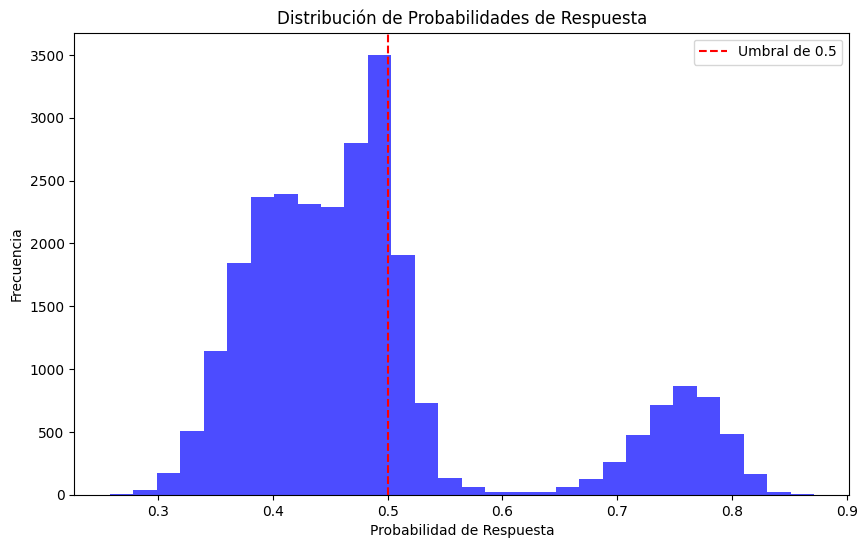

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Año,Categoria_top,Categoria_menos_frecuente,Categorias_distintas,Canal_preferido,...,Cluster_Economico,Tasa_Retorno_Promedio,s_Importe_total,s_Frecuencia,s_Ticket_medio,s_Dias_ultima,s_Tasa_Retorno,score,Probabilidad_respuesta,Respondio
0,C100004,130.43,32.6075,4,711,2023,6,6,1,0,...,0,0.125,0.012173,0.214286,0.005776,0.487320,0.0,0.091834,0.366060,0
1,C100005,196.48,98.2400,2,110,2024,3,6,2,0,...,3,0.175,0.018583,0.071429,0.019509,0.075394,0.2,0.021117,0.353695,1
2,C100006,497.88,99.5760,5,254,2024,3,2,3,0,...,0,0.125,0.047834,0.285714,0.019789,0.174092,0.0,0.268900,0.396776,1
3,C100012,423.60,70.6000,6,200,2024,5,4,5,0,...,1,0.275,0.040625,0.357143,0.013726,0.137080,0.6,0.718826,0.770644,1
4,C100019,120.13,60.0650,2,634,2023,6,6,1,0,...,0,0.125,0.011173,0.071429,0.011521,0.434544,0.0,-0.168075,0.320656,0


In [10]:
df_prob = pd.DataFrame(predicciones.flatten(), columns=['Probabilidad'])
df_prob['Prediccion_Label'] = (df_prob['Probabilidad'] > 0.5).astype(int)
df_prob['Prediccion_Label'] = df_prob['Prediccion_Label'].map({0: 'No Responde', 1: 'Responde'})
# 2. Visualizar las predicciones
plt.figure(figsize=(10, 6))
df_prob['Probabilidad'].hist(bins=30, color='blue', alpha=0.7)
plt.title('Distribución de Probabilidades de Respuesta')
plt.xlabel('Probabilidad de Respuesta')
plt.ylabel('Frecuencia')
plt.axvline(x=0.5, color='red', linestyle='--', label='Umbral de 0.5')
plt.legend()
plt.grid()
plt.show()

df.head()


---

##### 3.1.5 Guardamos los datos predichos y los modelos para que puedan ser utilizados en cualquier momento sin tener que volver a entrenar.

In [11]:
df.to_excel('./Data/Resultados/segmentacion_responde.xlsx', index=False)

In [12]:
joblib.dump(scaler, './Modelos/scaler_responde.pkl')

['./Modelos/scaler_responde.pkl']

In [13]:
model_sec.save('./Modelos/responde_campana.keras')

In [14]:
joblib.dump(scaler_sim, './Modelos/scaler_simulacion.pkl')

['./Modelos/scaler_simulacion.pkl']

In [15]:
# Guardar LabelEncoders
for col, le in label_encoders.items():
    joblib.dump(le, f'./Modelos/labelencoder_{col}.pkl')

#### 3.2 Segundo Modelo  
**Predicciones del importe total, ticket medio y frecuencia tras aplicar una campaña y sin aplicar una campaña en un determinado año**

Para llevar a cabo este modelo predictivo, debido a que no tenemos una campaña previa con la que entrenar, vamos a simular la aplicación de una campaña por segmento. Esta simulación la vamos a hacer en base a las campañas definidas por segmento para este trabajo. Una vez simulada la campaña para cada segmento de clientes, se realizará el entrenamiento para dichos datos y posteriormente realizaremos la predicción para un año posterior.

Para aplicar las campañas hemos tenido en cuenta lo siguiente:

![Detalle Campañas](campañas.png)



#### 3.2.1 Preparación datos para el modelo
Lo primero que haremos es predecir con el modelo anterior el total de los datos y una vez lo tengamos con la columna de prediccion de si respondera a una campaña o no, procederemos a realizar una copia de ese data frame para poder usar los datos en el train, test y val del nuevo modelo de predicción

In [16]:
predicciones_totales = model_sec.predict(X_total_scaled)
print(predicciones_totales)
df_prob_total = pd.DataFrame(predicciones.flatten(), columns=['Probabilidad'])
df_prob_total['Prediccion_Label'] = (df_prob_total['Probabilidad'] > 0.5).astype(int)
df_prob_total['Prediccion_Label'] = df_prob_total['Prediccion_Label'].map({0: 'No Responde', 1: 'Responde'})

df_pred = pd.concat([data, df_prob_total], axis=1)
df_sim = df_pred.copy()

4101/4101 ━━━━━━━━━━━━━━━━━━━━ 4s 961us/step
[[0.46952805]
 [0.4518608 ]
 [0.47765172]
 ...
 [0.4173085 ]
 [0.44603926]
 [0.8048229 ]]


#### 3.2.2 Simulación de aplicación de alguna de las campañas definidas y detalladas anteriormente y la no aplicación de campañas

Para realizar la aplicación de campaña, la realizaremos como se detalla a continuación: se aplicará a un porcentaje de los datos agrupados por segmentos, y las campañas a aplicar son las siguientes:

- **C01 - Top Elite**: +22% en facturación  
- **C02 - ECI lovers**: +12% en ticket medio (suponemos que también afecta al importe)  
- **C03 - Ocasionales**: +7% en frecuencia  
- **C04 - Estables**: +10% en facturación  
- **C05 - Dormidos**: +6% de reactivación


In [17]:
df_sim['campaña'] = 'ninguna'

# C01 - Top Elite - +22% facturación
idx = df_sim.query("Cluster_Economico == 'Top Elite'").sample(frac=0.6, random_state=1).index
df_sim.loc[idx, 'campaña'] = 'C01'
df_sim.loc[idx, 'Importe_total'] *= 1.22

# C02 - ECI lovers - +12% ticket medio (suponemos que afecta importe también)
idx = df_sim.query("Cluster_Economico == 'ECI Lovers'").sample(frac=0.5, random_state=2).index
df_sim.loc[idx, 'campaña'] = 'C02'
df_sim.loc[idx, 'Ticket_medio'] *= 1.12

# C03 - Ocasionales - +7% frecuencia
idx = df_sim.query("Cluster_Economico == 'Ocasionales'").sample(frac=0.4, random_state=3).index
df_sim.loc[idx, 'campaña'] = 'C03'
df_sim.loc[idx, 'Frecuencia'] *= 1.07

# C04 - Estables - +10% facturación
idx = df_sim.query("Cluster_Economico == 'Estables'").sample(frac=0.4, random_state=4).index
df_sim.loc[idx, 'campaña'] = 'C04'
df_sim.loc[idx, 'Importe_total'] *= 1.10

# C05 - Dormidos - +6% reactivación
idx = df_sim.query("Cluster_Economico == 'Dormidos'").sample(frac=0.3, random_state=5).index
df_sim.loc[idx, 'campaña'] = 'C05'
df_sim.loc[idx, 'Importe_total'] *= 1.06
df_sim.loc[idx, 'Frecuencia'] *= 1.03  # Asumimos ligera reactivación


#### 3.2.3 Procesamiento de las variables para el modelo

Se definen y se procesan las variables para el modelo:

- **Variables de entrada**: Todas las del data frame menos 'Frecuencia', 'Importe_total', 'Categoria_top', 'Metodo_pago', 'Canal_preferido'
- **Variables objetivo**: 
    - **Categóricas**: 'Categoria_top', 'Metodo_pago', 'Canal_preferido', será escaladas con StandarScaler()
    - **Numéricas**: 'Frecuencia', 'Importe_total', 'Ticket_medio', será codificadas con OrdinalEncoder()


In [18]:
X = df_sim.drop(columns=['Frecuencia', 'Importe_total', 'Categoria_top', 'Metodo_pago', 'Canal_preferido'])
y_reg = df_sim[['Frecuencia', 'Importe_total', 'Ticket_medio']]
y_clf = df_sim[['Categoria_top', 'Metodo_pago', 'Canal_preferido']]

categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include='number').columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
])

#### 3.2.4 Análisis de modelos

### Justificación de la Elección del Modelo

Para la construcción de los modelos predictivos, se ha optado por el uso de algoritmos **Random Forest**, tanto para problemas de regresión como de clasificación. 
A continuación, se detalla la justificación de esta decisión:

---

#### ¿Por qué Random Forest?

**Random Forest** es un algoritmo basado en árboles de decisión que combina múltiples árboles (bagging) para mejorar la precisión y reducir el sobreajuste. Las razones específicas por las que se ha elegido este algoritmo son:

- **Robustez ante datos ruidosos y multicolinealidad**: Random Forest maneja bien variables correlacionadas y datos con outliers.
- **Versatilidad**: Funciona eficientemente tanto en tareas de regresión como de clasificación.
- **Importancia de variables**: Permite obtener métricas de importancia que ayudan a entender qué variables están influyendo más en las predicciones.
- **Escalabilidad y paralelización**: El parámetro 'n_jobs=-1' permite aprovechar todos los núcleos de procesamiento, lo que es clave con grandes volúmenes de datos.

---

### ¿Por qué Random Forest es Mejor frente a Otros Modelos?

La elección de **Random Forest** se ha realizado tras comparar sus ventajas frente a otros algoritmos comunes en problemas similares, considerando tanto la naturaleza de los datos como los objetivos del proyecto.

---

#### Comparación con Otros Algoritmos

| Algoritmo               | Ventajas                                                   | Limitaciones                                                  |
|-------------------------|------------------------------------------------------------|----------------------------------------------------------------|
| **Random Forest**       | - Robusto ante overfitting<br>- Maneja bien datos no lineales y ruido<br>- Requiere poca preparación de datos | - Menos interpretable que un árbol único<br>- Más costoso computacionalmente |
| Regresión lineal / logística | - Muy interpretables<br>- Rápidos de entrenar           | - Suponen relaciones lineales<br>- Sensibles a outliers y multicolinealidad |
| Árbol de decisión único | - Fácil de interpretar                                     | - Alta varianza (overfitting)<br>- Menor precisión general     |
| K-Nearest Neighbors (KNN) | - Intuitivo y sin entrenamiento complejo                 | - Muy lento con grandes datasets<br>- Sensible a la escala de los datos |
| XGBoost / LightGBM      | - Mayor precisión en competiciones                         | - Más complejo de configurar<br>- Difícil interpretación para negocio |
| SVM                     | - Buen desempeño en espacios complejos                    | - Poco escalable<br>- Requiere mucha preparación de datos      |

---

#### Ventajas Específicas de Random Forest en Este Proyecto

1. **Equilibrio entre precisión y estabilidad**: Random Forest ofrece un rendimiento alto sin ser tan propenso al sobreajuste como un árbol individual o tan complejo como XGBoost.

2. **Manejo de variables categóricas y numéricas sin escalar**: A diferencia de SVM o KNN, no necesita normalización ni codificación excesiva.

3. **Importancia de variables**: Ideal para proyectos donde también se desea interpretar qué variables influyen más en el comportamiento del cliente.

4. **Robustez frente a datos reales**: Este dataset probablemente tenga ruido, datos atípicos y correlaciones entre variables. Random Forest lo maneja muy bien.

5. **Facilidad de implementación y mantenimiento**: Menos sensible a hiperparámetros que XGBoost, con buen rendimiento "out of the box".

---

### Conclusión

Si bien hay algoritmos más sofisticados en ciertos contextos, **Random Forest representa un excelente equilibrio entre rendimiento, interpretabilidad y facilidad de implementación**. Por eso, es una elección óptima para predicciones de comportamiento del cliente en escenarios reales como este.


#### 3.2.5 Empezamos a definir nuestro modelo

Una vez elegido el modelo, empezamos con la preparación de las distintas *pipelines* y métodos que nos ayudarán a tener el código más optimizado. Además, nos será más fácil la aplicación, ya que debemos crear un modelo por variable objetivo. Esto nos facilitará el trabajo. 

Por ejemplo, vamos a tener:
- Un método para crear el *pipeline* de cada modelo.
- Otro método que realice el *train* y *predict* de los mismos.


In [19]:
def build_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

def train_and_predict(X, y, model, tipo='regresion'):
    pipeline = build_pipeline(model)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    result = {
        'pipeline': pipeline,
        'y_pred_all': pipeline.predict(X)
    }

    if tipo == 'regresion':
        result.update({
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': mean_squared_error(y_test, y_pred, squared=False),
            'R2': r2_score(y_test, y_pred)
        })
    else:
        result.update({
            'Accuracy': accuracy_score(y_test, y_pred)
        })

    return result

In [20]:
reg_models = {
    'Frecuencia': RandomForestRegressor(n_estimators=50, max_depth=12, random_state=0, n_jobs=-1),
    'Importe_total': RandomForestRegressor(n_estimators=50, max_depth=12, random_state=0, n_jobs=-1),
    'Ticket_medio': RandomForestRegressor(n_estimators=50, max_depth=12, random_state=0, n_jobs=-1)
}

clf_models = {
    'Categoria_top': RandomForestClassifier(n_estimators=50, max_depth=12, random_state=0, class_weight='balanced', n_jobs=-1),
    'Metodo_pago': RandomForestClassifier(n_estimators=50, max_depth=12, random_state=0, class_weight='balanced', n_jobs=-1),
    'Canal_preferido': RandomForestClassifier(n_estimators=50, max_depth=12, random_state=0, class_weight='balanced', n_jobs=-1)
}

pipelines = {}

for col, model in reg_models.items():
    result = train_and_predict(X, y_reg[col], model, tipo='regresion')
    df_sim[f'Prediccion_{col}'] = result['y_pred_all']
    pipelines[col] = result['pipeline']

for col, model in clf_models.items():
    result = train_and_predict(X, y_clf[col], model, tipo='clasificacion')
    df_sim[f'Prediccion_{col}'] = result['y_pred_all']
    pipelines[col] = result['pipeline']

#### 3.2.6 Preparación de datos con las campañas y predicción
Ya definidos los modelos, procedemos a asignar campañas a los datos que tenemos de entrenamiento de los años de históricos de clientes con los que contamos

In [21]:
campañas = {
    'C01': {'cluster': 'Top Elite',      'uplift_importe': 0.22, 'uplift_frecuencia': 0.00},
    'C02': {'cluster': 'ECI Lovers',     'uplift_importe': 0.12, 'uplift_frecuencia': 0.00},
    'C03': {'cluster': 'Ocasionales',    'uplift_importe': 0.00, 'uplift_frecuencia': 0.07},
    'C04': {'cluster': 'Estables',       'uplift_importe': 0.10, 'uplift_frecuencia': 0.00},
    'C05': {'cluster': 'Dormidos',       'uplift_importe': 0.06, 'uplift_frecuencia': 0.03},
}

prob_responder = 0.3


df_all = []
for id_campaña, info in campañas.items():
    cluster = info['cluster']
    
    # Filtramos solo clientes del segmento correspondiente
    idx_segmento = X[X['Cluster_Economico'] == cluster].index
    if len(idx_segmento) == 0:
        continue
    
    X_base = X.loc[idx_segmento].copy()
    
    # Simulamos con y sin campaña
    X_sin = X_base.copy()
    X_sin['campaña'] = 'ninguna'

    X_con = X_base.copy()
    X_con['campaña'] = id_campaña

    # Predicción importe total
    pred_sin = pipelines['Importe_total'].predict(X_sin)
    pred_con = pipelines['Importe_total'].predict(X_con)

    #Prediccion de frecuencia
    pred_frec_sin = pipelines['Frecuencia'].predict(X_sin)
    pred_frec_con = pipelines['Frecuencia'].predict(X_con)

    #Predicción de ticket medio
    pred_ticket_sin = pipelines['Ticket_medio'].predict(X_sin)
    pred_ticket_con = pipelines['Ticket_medio'].predict(X_con)

    if id_campaña in ['C02', 'C03']:
       #Para estas campañas calculamos el prediccion de importe total como ticket medio * frecuencia
        pred_sin = pred_frec_sin * pred_ticket_sin
        pred_con = pred_frec_con * pred_ticket_con

    uplift = pred_con - pred_sin
    ingreso_esperado = prob_responder * uplift


    # Creamos DataFrame de resultados
    df_tmp = X_base.copy()
    df_tmp['campaña_simulada'] = id_campaña
    df_tmp['pred_sin_campaña'] = pred_sin
    df_tmp['pred_con_campaña'] = pred_con
    df_tmp['pred_sin_campaña_tick'] = pred_ticket_sin
    df_tmp['pred_con_campaña_tick'] = pred_ticket_con
    df_tmp['pred_sin_campaña_frec'] = pred_frec_sin
    df_tmp['pred_con_campaña_frec'] = pred_frec_con
    df_tmp['uplift'] = uplift
    df_tmp['prob_responder'] = prob_responder
    df_tmp['ingreso_esperado'] = ingreso_esperado
    df_all.append(df_tmp)
    

# Unimos resultados de todas las campañas
df_resultados = pd.concat(df_all).reset_index(drop=True)


#### 3.2.7 Predicción para año futuro

Una vez entrenado y validado el modelo con los datos históricos y con la simulación de campañas aplicada, procedemos a predecir, en este caso, los datos para el año 2025

In [22]:
df_2025 = df_resultados.copy()
 
# Si columna 'Año', actualizamos a 2025
if 'Año' in df_2025.columns:
    df_2025['Año'] = 2025
else:
    df_2025['Año'] = 2025  # Añadir una columna de año si no existe
 
# Eliminar columnas target para simular predicciones
cols_a_eliminar = ['Frecuencia', 'Importe_total', 'Categoria_top', 'Metodo_pago', 'Canal_preferido']

cols_a_eliminar = [col for col in cols_a_eliminar if col in df_2025.columns]
if cols_a_eliminar:
    df_2025 = df_2025.drop(columns=cols_a_eliminar)

# ============================
# 2. Predicciones SIN campaña
# ============================
df_2025_sin = df_2025.copy()
df_2025_sin['campaña'] = 'Ninguna'
X_2025_sin = df_2025_sin

df_2025['Importe_pred_sin'] = pipelines['Importe_total'].predict(X_2025_sin)
df_2025['Frecuencia_pred_sin'] = pipelines['Frecuencia'].predict(X_2025_sin)
df_2025['Ticket_medio_pred_sin'] = pipelines['Ticket_medio'].predict(X_2025_sin)

# ============================
# 3. Predicciones CON campaña por cluster
# ============================

# Mapeo de campañas por cluster económico
campañas = {
    'C01': {'cluster': 'Top Elite',      'impacto': 0.225},  # promedio de 20-25%
    'C02': {'cluster': 'ECI Lovers',     'impacto': 0.125},  # promedio de 10-15%
    'C03': {'cluster': 'Ocasionales',    'impacto': 0.075},  # promedio de 5-10%
    'C04': {'cluster': 'Estables',       'impacto': 0.10},   # promedio de 8-12%
    'C05': {'cluster': 'Dormidos',       'impacto': 0.065}   # promedio de 5-8%
}

df_all_2025 = []

for id_campaña, info in campañas.items():
    cluster = info['cluster']
    impacto = info['impacto']
    
    # Filtrar por cluster económico
    df_cluster = df_2025[df_2025['Cluster_Economico'] == cluster].copy()
    if df_cluster.empty:
        continue

    df_cluster['campaña'] = id_campaña
    df_cluster['Importe_pred_con'] = pipelines['Importe_total'].predict(df_cluster)
    df_cluster['Frecuencia_pred_con'] = pipelines['Frecuencia'].predict(df_cluster)
    df_cluster['Ticket_medio_pred_con'] = pipelines['Ticket_medio'].predict(df_cluster)

    if id_campaña in ['C02', 'C03']:
       #Para estas campañas calculamos el prediccion de importe total como ticket medio * frecuencia
        df_cluster['Importe_pred_con'] = df_cluster['Frecuencia_pred_con'] * df_cluster['Ticket_medio_pred_con']
        
    # Aplicar uplift estimado
    df_cluster['Importe_pred_con'] *= (1 + impacto)

    prob_responder = 0.3
    df_cluster['Uplift'] = df_cluster['Importe_pred_con'] - df_cluster['Importe_pred_sin']
    df_cluster['Ingreso_esperado'] = prob_responder * df_cluster['Uplift']
    df_cluster['campaña_asignada'] = id_campaña

    df_all_2025.append(df_cluster)

# Unir todos los clientes con campaña
df_2025_con = pd.concat(df_all_2025).reset_index(drop=True)

# ============================
# 4. Completar con clientes sin campaña asignada
# ============================
clientes_sin_campaña = df_2025[~df_2025['ID_Cliente'].isin(df_2025_con['ID_Cliente'])].copy()
clientes_sin_campaña['campaña'] = 'Ninguna'
clientes_sin_campaña['Importe_pred_con'] = clientes_sin_campaña['Importe_pred_sin']
clientes_sin_campaña['Frecuencia_pred_con'] = clientes_sin_campaña['Frecuencia_pred_sin']
clientes_sin_campaña['Uplift'] = 0
clientes_sin_campaña['Ingreso_esperado'] = 0
clientes_sin_campaña['campaña_asignada'] = 'Ninguna'

df_2025_completo = pd.concat([df_2025_con, clientes_sin_campaña], ignore_index=True)

# ============================
# 5. Resumen de resultados para 2025
# ============================
required_columns = ['Importe_pred_sin', 'Importe_pred_con', 'Uplift', 'Ingreso_esperado']
missing_columns = [col for col in required_columns if col not in df_2025_completo.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing in df_2025_completo: {missing_columns}")

resumen_2025 = df_2025_completo[required_columns]
print("==== Proyección para el año 2025 ====")
print(resumen_2025.describe())



==== Proyección para el año 2025 ====
       Importe_pred_sin  Importe_pred_con         Uplift  Ingreso_esperado
count     131224.000000     131224.000000  131224.000000     131224.000000
mean         491.765074        518.933714      27.168640          8.150592
std          580.307323        696.892846     137.447706         41.234312
min            5.200016          5.538017    -152.645102        -45.793531
25%          207.567431        235.383261     -24.271832         -7.281550
50%          407.862047        392.219398       6.934442          2.080333
75%          613.436528        600.880580      31.062484          9.318745
max         9542.032848      11688.990239    2146.957391        644.087217


In [23]:


df_2025_completo.to_excel('./Data/Resultados/proyeccion_ventas_2025.xlsx', index=False)


---

## 4. Gráficos
Vamos a mostrar algunos datos obtenidos mediante gráficos

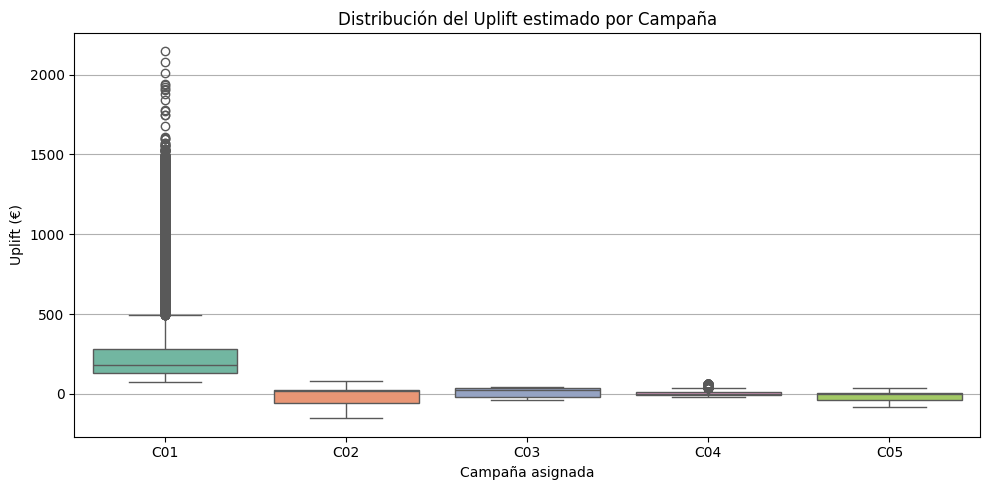

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_2025_completo[df_2025_completo['campaña_asignada'] != 'Ninguna'],
            x='campaña_asignada', y='Uplift', palette='Set2')
plt.title('Distribución del Uplift estimado por Campaña')
plt.ylabel('Uplift (€)')
plt.xlabel('Campaña asignada')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


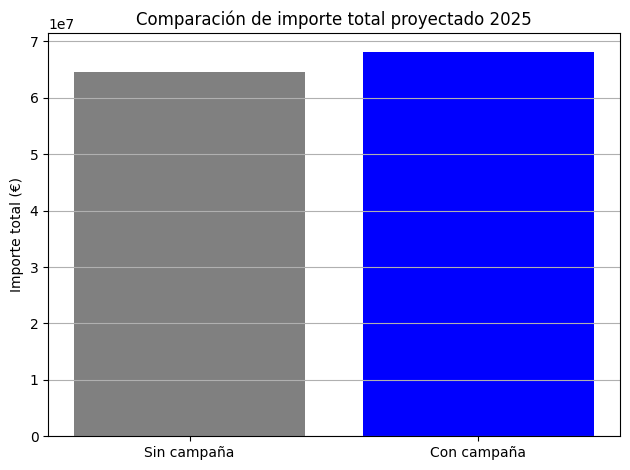

In [25]:
sin_total = df_2025_completo['Importe_pred_sin'].sum()
con_total = df_2025_completo['Importe_pred_con'].sum()

plt.bar(['Sin campaña', 'Con campaña'], [sin_total, con_total], color=['gray', 'blue'])
plt.title('Comparación de importe total proyectado 2025')
plt.ylabel('Importe total (€)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


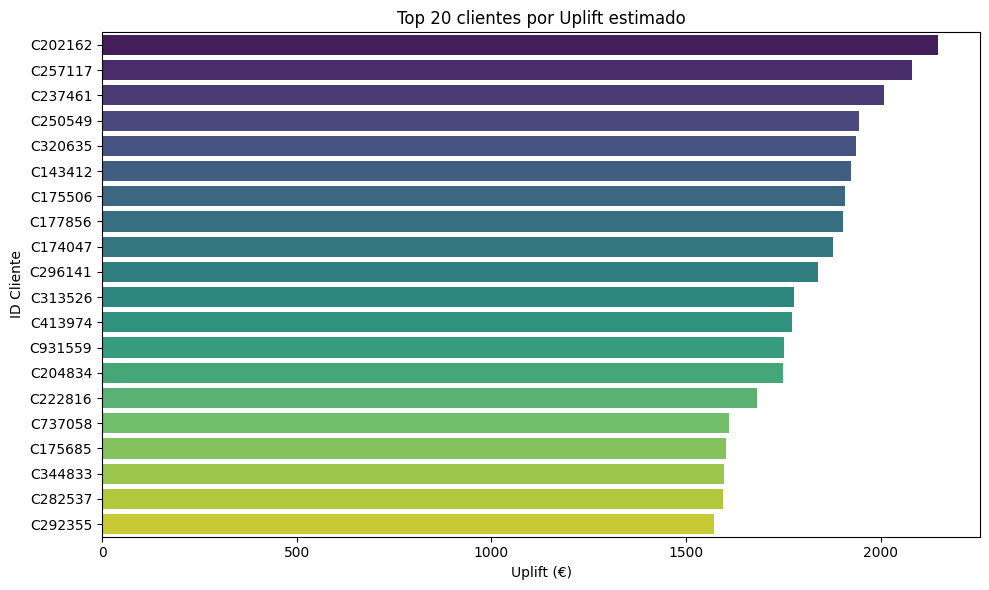

In [27]:
top_uplift = df_2025_completo.sort_values('Uplift', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_uplift, x='Uplift', y='ID_Cliente', palette='viridis')
plt.title('Top 20 clientes por Uplift estimado')
plt.xlabel('Uplift (€)')
plt.ylabel('ID Cliente')
plt.tight_layout()
plt.show()
